---

## Homework


Can you make a perfect classifier? Let's consider the next dataset:

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import time
from IPython import display
from sklearn.model_selection import ParameterGrid
import pandas as pd


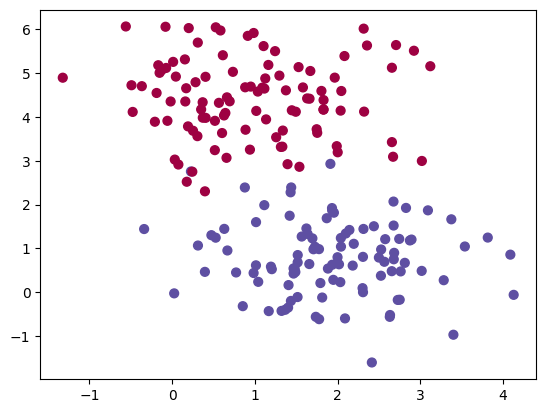

X.shape= (200, 2)


In [56]:
np.random.seed(0)
N = 200
X_test, y_test = sklearn.datasets.make_blobs(N, centers=2, cluster_std=0.9)

def show_scatter(x, y):
    plt.scatter(x[:,0], x[:,1], s=40, c=y, cmap=plt.cm.Spectral)
    plt.show()
    
show_scatter(X_test, y_test)
print('X.shape=', X_test.shape)

#### 1. Try to tune the learning rate and number of iterations
*What is the lowest error with the current approach?*

Add early stopping to find the optimal number of iterations automatically.

Visualize the decision boundary

iterations= 22 error= 0.06 angle= 327.9


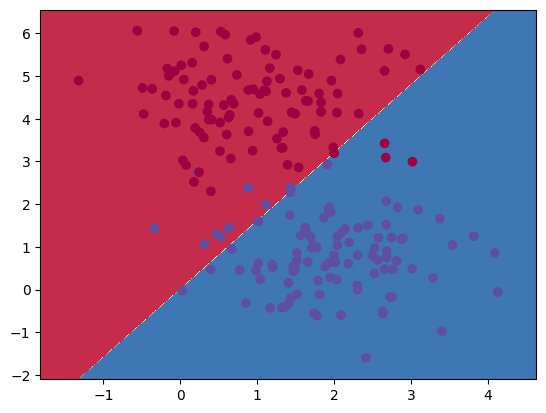

In [57]:
def plot_decision_boundary(x, y, pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def activation(x):
    return np.where( x > 0 , 1, 0)

def perceptron(w, x):
    return activation(w.dot(x))

def get_weights(angle):
    # Classificator is a line in 2D space. In genrel n-dimensional case, classificator is a hyperplane.
    # Hyperplane can be defined by a normal vector. Let's present it as (n-1) angles and a norm.
    # In the first homework task dimention is 2 and norm equals zero, so we need only one angle.
    w = np.array([np.cos(angle), np.sin(angle)])
    return w

def get_error(x, y, angle):
    w = get_weights(angle)

    v = perceptron(w, x.T)
    diff = y - v    
    err = np.mean(np.abs(diff))
    
    if is_interactive:
        display.clear_output(wait=True)
        plot_decision_boundary(x, y, lambda x: perceptron(w, x.T))
    
    return err


def run_perceptron(
        x,
        y,
        angle_step_default,
        angle_step_forward_coef,
        angle_step_backward_coef,
        
        max_iterations_wo_min_improvement = 10,
        max_iterations = 100
    ):
    angle_step = angle_step_default
    angle = 0 # starting angle

    iterations_to_min_error = 1
    iterations_since_min_error = 0
    min_error_angle = angle
    min_error = error = get_error(x, y, angle)

    # iIf we're lucky and initial angle is correct, we can finish in one iteration
    if error > 0:
        
        # Limiting number of iterations to avoid infinite loop
        for j in range(max_iterations-1): # First has been already taken
            
            # On each iteration we're adjusting angle according to the previous run results
            angle =  angle + angle_step
            new_error = get_error(x, y, angle)

            iterations_since_min_error += 1
            
            # If direction is correct (error decreases) - accelerate to come to the goal faster
            if new_error <= error:
                angle_step = angle_step*angle_step_forward_coef
                
                # Store parameters of the best result
                if new_error < min_error:
                    min_error = new_error
                    min_error_angle = angle
                    iterations_since_min_error = 0
                    iterations_to_min_error = j + 2 # +1 for first iteration, +1 for 0-based index
                    
                    # Absolute goal is zero, stop here
                    if new_error == 0:
                        break
            
            # If we end up in a situation where most of points are classified incorrectly, just flip the line and have them on the other side
            elif new_error > 0.5:
                angle = angle + np.pi
                angle_step = angle_step_default
                 
            # If direction is incorrect (error increases, but stays below 0.5) - step back and decelerate            
            # The art here is to find the right coeficient, so we converge to minimum but have an abiity to jumo out from a local minimum
            else:
                angle_step = angle_step*angle_step_backward_coef
                
            # Vuisualize if human is watching the progress
            if is_interactive:
                print('j=', j+2, 'error=', error, 'new_error=', new_error, ' =>  angle=', np.rad2deg(angle).round(1), 'angle_step=', np.rad2deg(angle_step).round(1))
                time.sleep(0.3)
            
            # Give up if we're not improving for a long time
            if iterations_since_min_error >= max_iterations_wo_min_improvement:
                break
            
            error = new_error
    
    return np.mod(min_error_angle, 2*np.pi), min_error, iterations_to_min_error + iterations_since_min_error

is_interactive = True

np.random.seed(0)
N = 200
X_test, y_test = sklearn.datasets.make_blobs(N, centers=2, cluster_std=0.9)

# The tricky part is to find right values for the coeficients. See an attempt below.
angle, error, steps = run_perceptron(X_test, y_test, np.pi/16, 1.45, -0.2)

display.clear_output(wait=True)
print('iterations=', steps, 'error=', error, 'angle=', np.rad2deg(angle).round(1))

# Visualize best-found result
w = get_weights(angle)
plot_decision_boundary(X_test, y_test, lambda x: perceptron(w, x.T))

# Best result so far is:
# error= 0.06 (6%), iterations= 22 (last 10 cycles w/o improvement), angle= 327.9 degrees

In [58]:
# An attempt to find the best parameters
# I ended up selecting teh best for random seed = 0, but the code is written to find optimal coeficients for a general case.

grid = ParameterGrid({
    'angle_step_default': [np.pi/16], # some small value
    'angle_step_forward_coef': np.arange(0, 1, 0.05) + 1.05, # 1.05 to 2
    'angle_step_backward_coef': -np.arange(0.05, 1, 0.05), # -0.05 to -0.95
})

N = 200

r_list = np.arange(0, 100)
X_list=[]
y_list=[]

is_interactive = False
for r in r_list:
    np.random.seed(r)
    x, y = sklearn.datasets.make_blobs(N, centers=2, cluster_std=0.9)
    X_list.append(x)
    y_list.append(y)

results = []

for params in grid:
    for i, r in enumerate(r_list):
        x = X_list[i]
        y = y_list[i]
        angle, error, steps = run_perceptron(x, y, **params)
        results.append({
            'random_seed': r,
            'angle_step_default': params['angle_step_default'],
            'angle_step_forward_coef': params['angle_step_forward_coef'],
            'angle_step_backward_coef': params['angle_step_backward_coef'],
            'angle': angle,
            'error': error,
            'steps': steps
        })

df = pd.DataFrame(results)
df['min_error'] = np.inf
for r in r_list:
    df.loc[df['random_seed'] == r, 'min_error'] = df.loc[df['random_seed'] == r, 'error'].min()
    
# Take not just the best but also good enough, extend beyond the luck
df = df[(np.abs(df['min_error'] - df['error']) <= 0.01) & (df['steps'] > 3)]
df

,random_seed,angle_step_default,angle_step_forward_coef,angle_step_backward_coef,angle,error,steps,min_error
1,1,0.19635,1.05,-0.05,3.956934,0.000,5,0.000
2,2,0.19635,1.05,-0.05,0.196350,0.105,12,0.100
3,3,0.19635,1.05,-0.05,3.740459,0.000,4,0.000
5,5,0.19635,1.05,-0.05,0.684832,0.410,26,0.405
6,6,0.19635,1.05,-0.05,3.956934,0.000,5,0.000
...,...,...,...,...,...,...,...,...
37993,93,0.19635,2.00,-0.95,3.141593,0.000,7,0.000
37994,94,0.19635,2.00,-0.95,4.810564,0.020,23,0.015
37997,97,0.19635,2.00,-0.95,3.926991,0.000,4,0.000
37998,98,0.19635,2.00,-0.95,2.945243,0.000,5,0.000


In [59]:
d = df[df['random_seed'] == 0] # our test data
d[d['min_error'] == d['error']].sort_values('steps', ascending=True).head(10)

,random_seed,angle_step_default,angle_step_forward_coef,angle_step_backward_coef,angle,error,steps,min_error
6800,0,0.19635,1.45,-0.20,5.723071,0.06,22,0.06
20300,0,0.19635,1.20,-0.55,5.723035,0.06,26,0.06
22100,0,0.19635,1.10,-0.60,5.722954,0.06,29,0.06
8000,0,0.19635,1.05,-0.25,5.722512,0.06,33,0.06
22000,0,0.19635,1.05,-0.60,5.722572,0.06,34,0.06
5300,0,0.19635,1.70,-0.15,5.722672,0.06,35,0.06
16000,0,0.19635,1.05,-0.45,5.722396,0.06,35,0.06
4100,0,0.19635,1.10,-0.15,5.722873,0.06,37,0.06
4200,0,0.19635,1.15,-0.15,5.722392,0.06,38,0.06
5400,0,0.19635,1.75,-0.15,5.723086,0.06,43,0.06


In [60]:
# Can be used to find for a general case

# grouped_df = df.groupby(['angle_step_forward_coef', 'angle_step_backward_coef'])['steps'].agg(['mean', 'std', 'count']).reset_index()
# grouped_df.sort_values('mean', ascending=True).head(20)

#### 2. It's time to add learnable bias
*What is the lowest error now?*

Visualize the decision boundary

iterations= 128 error= 0.015 angle= 296.9 distance= -1.820209550406906


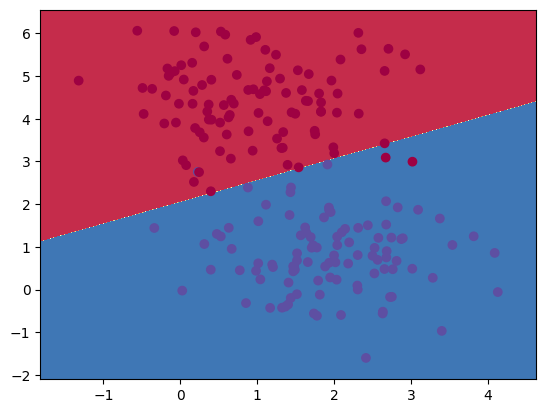

In [61]:
def add_ones(x):
    return np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)

def plot_decision_boundary(x, y, pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    x_m = np.c_[xx.ravel(), yy.ravel()]
    Z = pred_func(add_ones(x_m))
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()    

def get_weights(angle, distance):
    # Classificator is a line in 2D space. In genrel n-dimensional case, classificator is a hyperplane.
    # Hyperplane can be defined by a normal vector. Let's present it as (n-1) angles and a norm.
    # Taking this approach reduces the number of parameters to train by 1.
    w = np.array([np.cos(angle), np.sin(angle), -distance])
    return w

def get_error(x, y, angle, distance):
    w = get_weights(angle, distance)

    v = perceptron(w, x.T)
    diff = y - v    
    err = np.mean(np.abs(diff))
    
    if is_interactive:
        display.clear_output(wait=True)
        plot_decision_boundary(x, y, lambda x: perceptron(w, x.T))
    
    return err


def run_perceptron_with_bias(
        x_1,
        y,
        
        angle_step_default,
        angle_step_forward_coef,
        angle_step_backward_coef,
        
        distance_step_default,
        distance_step_forward_coef,
        distance_step_backward_coef,
        
        max_iterations_wo_min_improvement = 30,
        max_iterations = 200
    ):
    angle_step = angle_step_default
    distance_step = distance_step_default
    angle = 0 # starting angle
    distance = 0 # starting distance

    iterations_to_min_error = 1
    iterations_since_min_error = 0
    min_error_angle = angle
    min_error_distance = distance
    min_error = error = get_error(x_1, y, angle, distance)
    
    # If we're lucky and initial angle is correct, we can finish in one iteration
    if error > 0:
        
        # Limiting number of iterations to avoid infinite loop
        for j in range(max_iterations-1): # First has been already taken
            
            # On each iteration we're adjusting angle or distance according to the previous run results
            # Making all adjustments at once is too chaotic and gives no feedback which paramter needs to accelearte or decelerate.            
            # Doing a few steps in a row for one parameter allows to improve it.            
            fit_angle = j % 8 < 4
            
            # For n-dimentional case we would need an array of angles and tackle one at a time using the same techique.
            if fit_angle:
                angle =  angle + angle_step
            else:
                distance =  distance + distance_step
                
            new_error = get_error(x_1, y, angle, distance)

            iterations_since_min_error += 1
            
            # If direction is correct (error decreases) - accelerate to come to the goal faster
            # Ideally we would need to measure the distance beween centers of clasters and limit distance parameter, flipping iot back similar to angle.
            # To keep things simplier just don't allow distance to grow indefinitely and take small initial step value.
            if (fit_angle and new_error <= error) or (not fit_angle and new_error < error):
                if fit_angle:
                    angle_step = angle_step*angle_step_forward_coef
                else:
                    distance_step = distance_step*distance_step_forward_coef
                    
                # Store parameters of the best result
                if new_error < min_error:
                    min_error = new_error
                    min_error_angle = angle
                    min_error_distance = distance
                    iterations_since_min_error = 0
                    iterations_to_min_error = j + 2 # +1 for first iteration, +1 for 0-based index
                    if new_error == 0:
                        break
                    
            # If we end up in a situation where most of points are classified incorrectly, just flip the line and have them on the other side
            elif new_error > 0.5:
                angle = angle + np.pi
                
                # Reset steps to default, we don't want to have too hight coeficients at this moment
                angle_step = angle_step_default
                distance_step = -distance_step_default # No strong argument about the sign, why not to try?
                 
            # If direction is incorrect (error increases, but stays below 0.5) - step back and decelerate            
            # The art here is to find the right coeficient, so we converge to minimum but have an abiity to jumo out from a local minimum
            else:
                if fit_angle:
                    angle_step = angle_step*angle_step_backward_coef
                else:                    
                    distance_step = distance_step*distance_step_backward_coef                
                
            # Visualize if human is watching the progress
            if is_interactive:
                print('j=', j+2, 'error=', error, 'new_error=', new_error, ' =>  angle=', np.rad2deg(angle).round(1), 'angle_step=', np.rad2deg(angle_step).round(1), 'distance=', distance, 'distance_step=', distance_step)
                time.sleep(0.2)
            
            # Give up if we're not improving for a long time
            if iterations_since_min_error >=max_iterations_wo_min_improvement:
                break
            
            error = new_error
    
    return np.mod(min_error_angle, 2*np.pi),  min_error_distance, min_error, iterations_to_min_error + iterations_since_min_error


is_interactive = True
# is_interactive = False

np.random.seed(0)
N = 200
X_test, y_test = sklearn.datasets.make_blobs(N, centers=2, cluster_std=0.9)

X_test_1 = add_ones(X_test)

# Try and error approach was used here to get the coeficient values
angle, distance, error, steps = run_perceptron_with_bias(
    X_test_1, y_test, 
    np.pi/32, 1.45, -0.5,
    0.5, 1.8, -0.3,
)

# Visualize best-found result
display.clear_output(wait=True)
print('iterations=', steps, 'error=', error, 'angle=', np.rad2deg(angle).round(1), 'distance=', distance)

w = get_weights(angle, distance)
plot_decision_boundary(X_test_1, y_test, lambda x: perceptron(w, x.T))    

# Best result so far is:
# error= 0.015 (1.5%), iterations= 128 (with last 30 shallow cycles),  angle= 296.9, distance= -1.82

#### 3*. Let's expand it for three classes

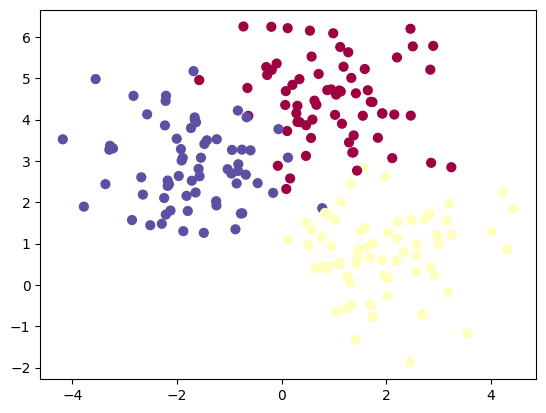

In [62]:
np.random.seed(0)
# X, y = sklearn.datasets.make_moons(200, noise=0.20)
x, y = sklearn.datasets.make_blobs(200)
plt.scatter(x[:,0], x[:,1], s=40, c=y, cmap=plt.cm.Spectral)

**Idea:** we need to train weights for each class 

\begin{equation}
y_p =   \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{p}^T \mathbf{w}_c^{\,}.
\end{equation}

Visualize the decision boundary

pair= [0, 1] iterations= 59 error= 0.022388059701492536 angle= 318.2 distance= -0.7671942342400004
pair= [0, 2] iterations= 36 error= 0.03759398496240601 angle= 195.3 distance= -0.5
pair= [1, 2] iterations= 55 error= 0.007518796992481203 angle= 150.4 distance= 0.6334961472000002


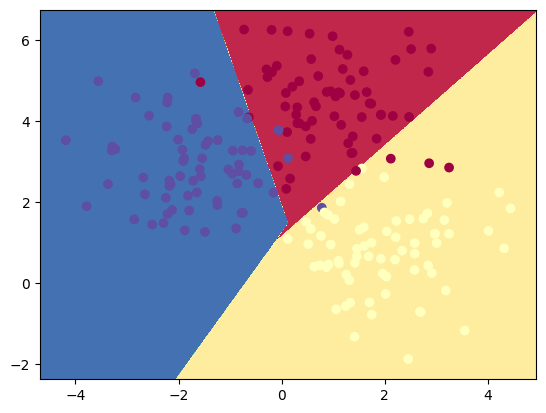

In [63]:
def plot_decision_boundary(x, y, pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    x_m = np.c_[xx.ravel(), yy.ravel()]
    Z = pred_func(add_ones(x_m))
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()    
    
    
np.random.seed(0)
N = 200
X, y = sklearn.datasets.make_blobs(N)

is_interactive = False

pairs = [[0,1],[0,2],[1,2]]
weights = []

for p in pairs:
    x_c1 = X[y==p[0]]
    x_c2 = X[y==p[1]]
    
    y_c1 = np.zeros(x_c1.shape[0])
    y_c2 = np.ones(x_c2.shape[0])
    
    X_test = np.concatenate((x_c1, x_c2))
    y_test = np.concatenate((y_c1, y_c2))
    
    X_test_1 = add_ones(X_test)
    
    angle, distance, error, steps = run_perceptron_with_bias(
        X_test_1, y_test, 
        np.pi/32, 1.45, -0.5,
        0.5, 1.8, -0.3,
    )
    print('pair=', p, 'iterations=', steps, 'error=', error, 'angle=', np.rad2deg(angle).round(1), 'distance=', distance)
    
    w = get_weights(angle, distance)
    weights.append(w)


def predict_class(x):
    y_pred = perceptron(np.array(weights), x.T).T
    df = pd.DataFrame(y_pred, columns=['t0', 't1', 't2']) # We ran 3 tests, pairing all classes
    df[['c0', 'c1', 'c2']] = 0
    for i, p in enumerate(pairs):
        t = 't' + str(i)
        df.loc[:, 'c' + str(p[0])] += np.mod(df[t] + 1, 2) # if 0 then add to class counter
        df.loc[:, 'c' + str(p[1])] += df[t] # if 1 then add to class counter
        
    rates = df[['c0', 'c1', 'c2']].to_numpy()
    
    return np.argmax(rates, axis=1)

plot_decision_boundary(X, y, predict_class)
